# *Notebook pour l'entraînement des modèles de Machine Learning*

## Sommaire

<ol>
    <li><a href="#">Import des librairies</a></li>
    <li><a href="#">Chargement des données</a></li>
    <li><a href="#">Feature importance</a></li>
    <li><a href="#">Préparation des données</a></li>
        <ol>
            <li><a href="#">Normalisation des données</a></li>
            <li><a href="#">Imputation des valeurs manquantes</a></li>
            <li><a href="#">Analyse en composantes principales (ACP)</a></li>
        </ol>
    <li><a href="#">Modélisation et évaluation des modèles</a></li>
        <ol>
            <li><a href="#">Modèle de référence</a></li>
            <li><a href="#">Métrique personnalisée</a></li>
            <li><a href="#">Oversampling avec SMOTE</a></li>
            <li><a href="#">Entraînement des différents modèles</a></li>
        </ol>
    <li><a href="#">Tableau récapitulatif</a></li>
    <li><a href="#">LIME and SHAP</a></li>
    <li><a href="#">Conclusion</a></li>
</ol>

## Import des librairies

In [1]:
%reload_ext autoreload
%autoreload 2

import gc
import random

# numpy et pandas pour la manipulation du data
import numpy as np
import pandas as pd

# sklearn
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing, model_selection, linear_model, metrics, impute, ensemble
from sklearn.svm import LinearSVC

from lightgbm import LGBMClassifier

import shap
shap.initjs()

# hyperopt
from hyperopt import fmin, tpe, hp, anneal, Trials, space_eval

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib et seaborn pour tracer les graphes
import matplotlib.pyplot as plt

#autres librairies
import missingno as msno

# Import des modules contenant les fonctions utilitaires
import src.my_module.data_helpers as dth

In [2]:
# Réglage des graphiques
plt.style.use('seaborn-whitegrid')

plt.rc('font', size=12)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)

dims_fig = (25,35)

## Chargement des données

On recupère le jeu de données sauvegardé à la fin de l'analyse et de la manipulation des données

In [3]:
data = pd.read_csv('merge.csv')
dth.displayDataShape("Le jeu de données contient", data)

Le jeu de données contient : 356251 lignes et 797 colonnes



On resépare notre jeu de données qui avait été fusionné lors de l'analyse.

On récupère un **train_data** qui contient la colonne TARGET avec des valeurs valorisées à 0 ou 1, et un **test_data** qui n'a que des NaN dans la colonne TARGET

In [4]:
train_data = data[data['TARGET'].notnull()]
test_data = data[data['TARGET'].isnull()]

In [5]:
dth.displayDataShape("Le jeu d'entraînement contient", train_data)

Le jeu d'entraînement contient : 307507 lignes et 797 colonnes



In [6]:
dth.displayDataShape("Le jeu de test contient", test_data)

Le jeu de test contient : 48744 lignes et 797 colonnes



In [7]:
del data
gc.collect()

0

In [10]:
train_data.head()

index  SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      0      100002     1.0                   0            1             0   
1      1      100003     0.0                   0            0             0   
2      2      100004     0.0                   1            1             1   
3      3      100006     0.0                   0            0             0   
4      4      100007     0.0                   0            1             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  ...  \
0                1             0          202500.0    406597.5  ...   
1                0             0          270000.0   1293502.5  ...   
2                1             0           67500.0    135000.0  ...   
3                1             0          135000.0    312682.5  ...   
4                1             0          121500.0    513000.0  ...   

   CC_NAME_CONTRACT_STATUS_Signed_MAX  CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
0                                 NaN                                  NaN   
1                                 NaN                                  NaN   
2                                 NaN                                  NaN   
3                                 0.0                                  0.0   
4                                 NaN                                  NaN   

   CC_NAME_CONTRACT_STATUS_Signed_SUM  CC_NAME_CONTRACT_STATUS_Signed_VAR  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 0.0                                 0.0   
4                                 NaN                                 NaN   

   CC_NAME_CONTRACT_STATUS_nan_MIN  CC_NAME_CONTRACT_STATUS_nan_MAX  \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                              NaN                              NaN   
3                              0.0                              0.0   
4                              NaN                              NaN   

   CC_NAME_CONTRACT_STATUS_nan_MEAN  CC_NAME_CONTRACT_STATUS_nan_SUM  \
0                               NaN                              NaN   
1                               NaN                              NaN   
2                               NaN                              NaN   
3                               0.0                              0.0   
4                               NaN                              NaN   

   CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
0                              NaN       NaN  
1                              NaN       NaN  
2                              NaN       NaN  
3                              0.0       6.0  
4                              NaN       NaN  

[5 rows x 797 columns]

## Feature importance

Le jeu de données est actuellement composé de 797 features, ce qui est beaucoup trop important pour entraîner nos modèles.

Il faut garder les features les plus pertinentes afin d'alléger les temps de calculs, et réduire la complexité, sans pour autant dégrader la précision de nos modèles.

Pour se faire, j'ai utilisé le script du fichier **lightGBM_script.ipynb**, qui est un script provenant d'un kernel Kaggle, et qui a permis d'aller plus vite sur la préparation des données. Dans ce script il y a également une partie sur l'entraînement d'un modèle lightGBM (un modèle de Light Gradient Boosting Machine), il est basé sur des algorithmes d'arbre de décision et utilisé pour le classement, la classification et d'autres tâches de machine learning.

A partir de ce modèle entraîné, on récupère les feature_importance, qui est le classement de toutes les features par ordre d'importance sur l'impact des décisions que le modèle va effectuer (ici il s'agit de prédire la TARGET à 0 ou 1).

Voici un début de ce classement en image :

![lgbm_importances01.png](data/img/lgbm_importances01.png)

Ces données sur l'importance des features issues du modèle lightGBM sont stockées dans le fichier **feature_importance.csv**.

On va récupérer les 100 features les plus importantes et se concentrer uniquement sur celles ci pour entraîner nos modèles par la suite.

In [11]:
feature_importance = pd.read_csv('feature_importance.csv').sort_values("importance", ascending=False)
feature_importance.head()

feature  importance  fold
3424  PAYMENT_RATE        3955     5
5014  PAYMENT_RATE        3872     7
32    EXT_SOURCE_3        3868     1
6604  PAYMENT_RATE        3764     9
7187  EXT_SOURCE_3        3753    10

In [12]:
features = feature_importance.groupby('feature').mean().sort_values("importance", ascending=False)
list_features = features[:100].index
new_train_data = train_data[list_features.insert(0, 'TARGET')]
new_test_data = test_data[list_features]

In [13]:
dth.displayDataShape("Le jeu d'entraînement contient", new_train_data)

Le jeu d'entraînement contient : 307507 lignes et 101 colonnes



In [14]:
dth.displayDataShape("Le jeu de test contient", new_test_data)

Le jeu de test contient : 48744 lignes et 100 colonnes



## Préparation des données

On va préparer les données avant de les utiliser pour l'entraînement des modèles.

Il faut d'abord séparer le data en un jeu de données pour l'entraînement et un autre pour les tests qui servira à mesurer la précision de notre modèle. (80% en données d'entraînement et 20% en données de test)

In [15]:
X = new_train_data.drop(['TARGET'], axis=1)
y = new_train_data['TARGET']

In [16]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

### Normalisation des données

On va maintenant normaliser les données, c'est à dire redimensionner les variables pour qu'elles soient comparables sur une échelle commune.

Afin d'éviter la fuite d'information entre les jeux d'entraînement et de test, les transformations sont apprises uniquement sur le jeu d'entraînement, et appliquées ensuite sur les 2 jeux de données.

In [17]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = pd.DataFrame(
    std_scale.transform(X_train),
    columns=X_train.columns
)
X_test_std = pd.DataFrame(
    std_scale.transform(X_test),
    columns=X_test.columns
)

In [18]:
X_train_std.describe()

PAYMENT_RATE  EXT_SOURCE_3  EXT_SOURCE_2    DAYS_BIRTH  EXT_SOURCE_1  \
count  2.459930e+05  1.971920e+05  2.454880e+05  2.460050e+05  1.073330e+05   
mean   4.054072e-16  3.073236e-16 -9.420777e-16  2.208514e-16  3.020213e-17   
std    1.000002e+00  1.000003e+00  1.000002e+00  1.000002e+00  1.000005e+00   
min   -1.406733e+00 -2.622034e+00 -2.692623e+00 -2.108025e+00 -2.313017e+00   
25%   -7.470884e-01 -7.207048e-01 -6.383520e-01 -8.344317e-01 -7.962200e-01   
50%   -1.643263e-01  1.249868e-01  2.700476e-01  6.506103e-02  1.762649e-02   
75%    4.615632e-01  8.122207e-01  7.820787e-01  8.304551e-01  8.187707e-01   
max    3.146820e+00  1.978084e+00  1.782710e+00  1.958489e+00  2.184932e+00   

       DAYS_EMPLOYED  DAYS_EMPLOYED_PERC  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
count   2.017620e+05        2.017620e+05       2.460050e+05     2.460050e+05   
mean   -4.440697e-17       -3.684731e-17      -3.059460e-17    -6.654794e-17   
std     1.000002e+00        1.000002e+00       1.000002e+00     1.000002e+00   
min    -6.639325e+00       -1.174026e+00      -5.586004e+00    -2.358019e+00   
25%    -3.381590e-01       -7.543647e-01      -7.059950e-01    -8.653580e-01   
50%     3.151307e-01       -2.851779e-01       1.375579e-01    -1.703727e-01   
75%     6.913708e-01        4.670780e-01       8.432143e-01     8.439480e-01   
max     1.018871e+00        4.282226e+00       1.414379e+00     1.982160e+00   

       INSTAL_DBD_MEAN  ...  PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN  \
count     2.332950e+05  ...                             2.327900e+05   
mean     -3.874208e-17  ...                            -1.408785e-15   
std       1.000002e+00  ...                             1.000002e+00   
min      -1.344401e+00  ...                            -9.592836e-01   
25%      -6.130567e-01  ...                            -9.592836e-01   
50%      -2.345623e-01  ...                            -1.167729e-01   
75%       3.156258e-01  ...                             7.257378e-01   
max       3.099978e+01  ...                             2.410759e+00   

       CLOSED_DAYS_CREDIT_MIN  CLOSED_DAYS_CREDIT_ENDDATE_MIN  \
count            1.840590e+05                    1.828420e+05   
mean             7.672680e-17                    6.096080e-17   
std              1.000003e+00                    1.000003e+00   
min             -1.316241e+00                   -2.544577e+01   
25%             -9.215648e-01                   -5.220924e-01   
50%             -1.560950e-01                   -5.079654e-02   
75%              8.368790e-01                    3.973721e-01   
max              2.343937e+00                    2.034306e+01   

       PREV_AMT_CREDIT_MEAN  PREV_RATE_DOWN_PAYMENT_MEAN  \
count          2.327900e+05                 2.188540e+05   
mean          -2.027761e-16                 9.847217e-16   
std            1.000002e+00                 1.000002e+00   
min           -1.025754e+00                -9.154011e-01   
25%           -6.229250e-01                -9.153177e-01   
50%           -3.173509e-01                -1.750727e-01   
75%            2.773877e-01                 2.984082e-01   
max            2.339142e+01                 1.011409e+01   

       APPROVED_APP_CREDIT_PERC_MIN  TOTALAREA_MODE  INSTAL_PAYMENT_PERC_VAR  \
count                  2.320000e+05    1.272930e+05             2.327120e+05   
mean                   1.704436e-16    1.126331e-16             1.058848e-15   
std                    1.000002e+00    1.000004e+00             1.000002e+00   
min                   -2.385128e+00   -9.523032e-01            -5.349342e-03   
25%                    2.380682e-02   -5.693876e-01            -5.349342e-03   
50%                    2.539085e-01   -3.147301e-01            -5.349342e-03   
75%                    5.325417e-01    2.317611e-01            -5.349306e-03   
max                    1.220322e+01    8.341765e+00             4.210049e+02   

       INSTAL_AMT_PAYMENT_MAX  PREV_AMT_APPLICATION_MEAN  
count            2

### Imputation des valeurs manquantes

Il y a encore des valeurs vides.

Pour pouvoir entraîner nos modèles, il va falloir imputer les valeurs manquantes.

<AxesSubplot:>

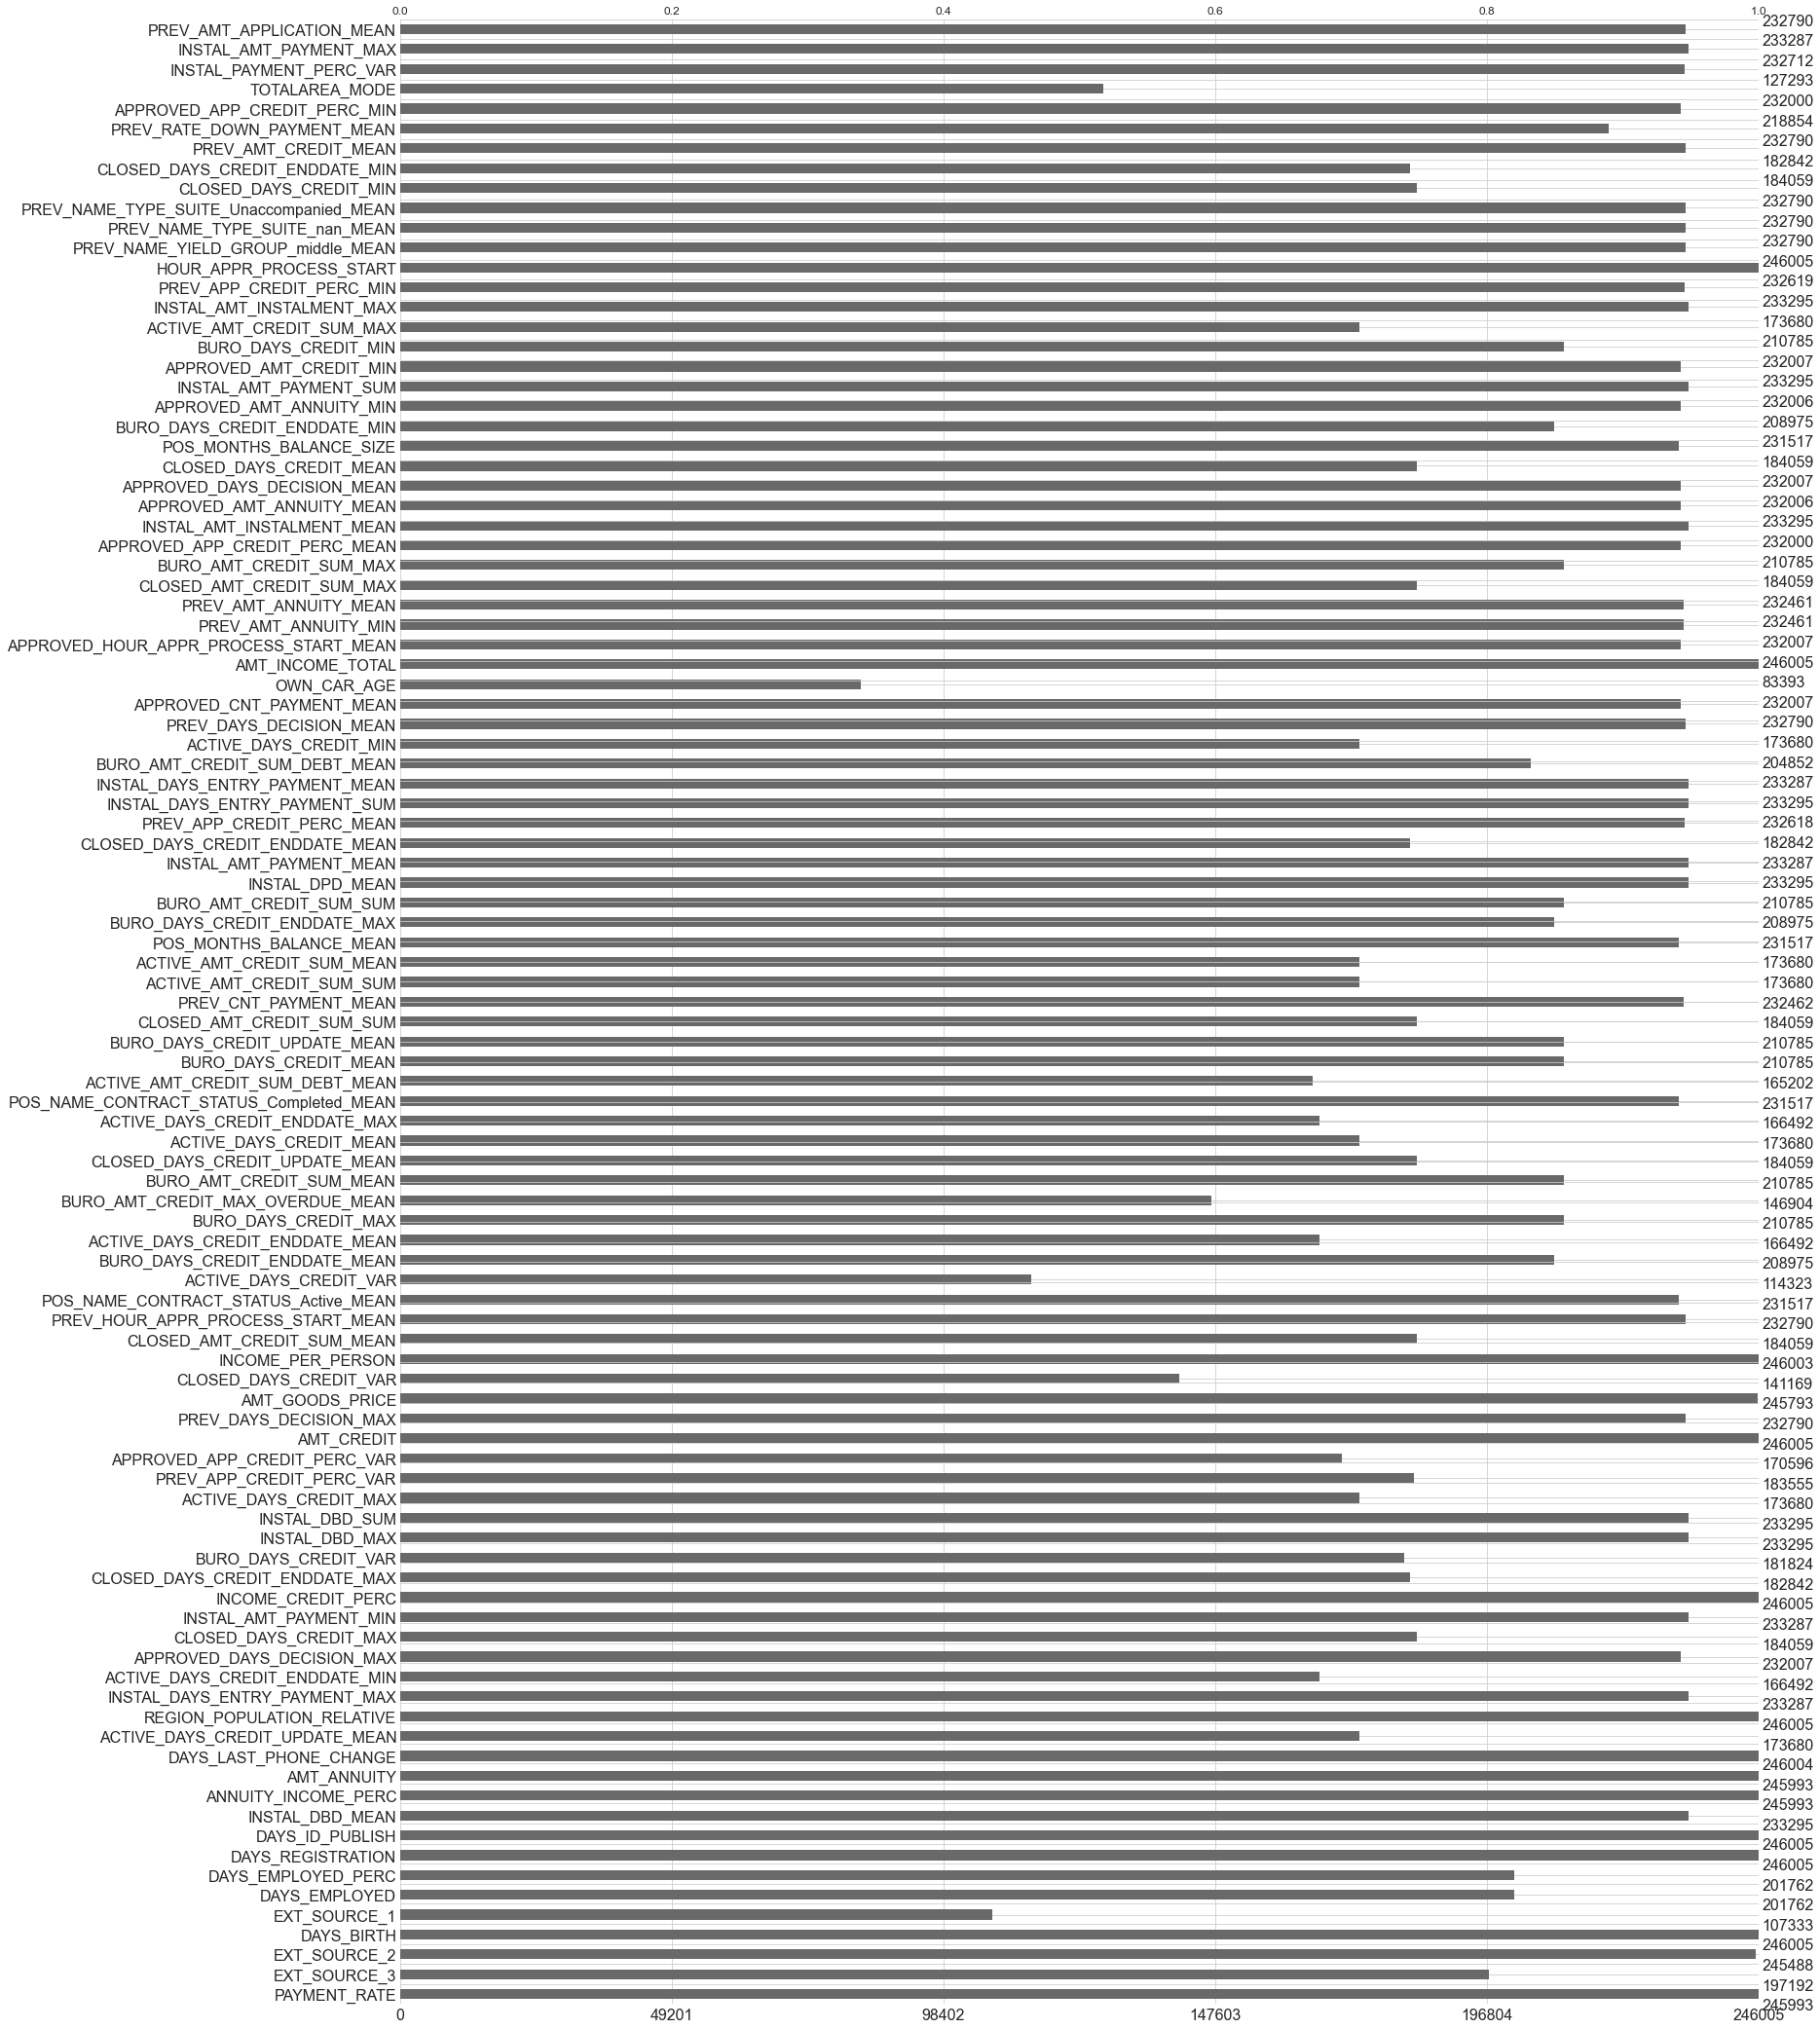

In [19]:
msno.bar(X_train_std)

In [20]:
imputer = impute.IterativeImputer(n_nearest_features=min(5, int(len(X_train_std.columns) / 10))).fit(X_train_std)

X_train_std = pd.DataFrame(
    imputer.transform(X_train_std),
    columns=X_train_std.columns
)

X_test_std = pd.DataFrame(
    imputer.transform(X_test_std),
    columns=X_test_std.columns
)

### Analyse en composantes principales (ACP)

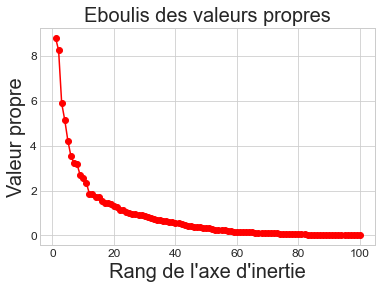

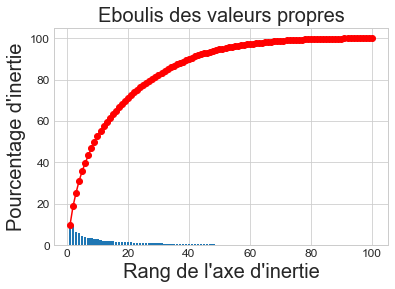

Le nombre de composantes à analyser est de 28


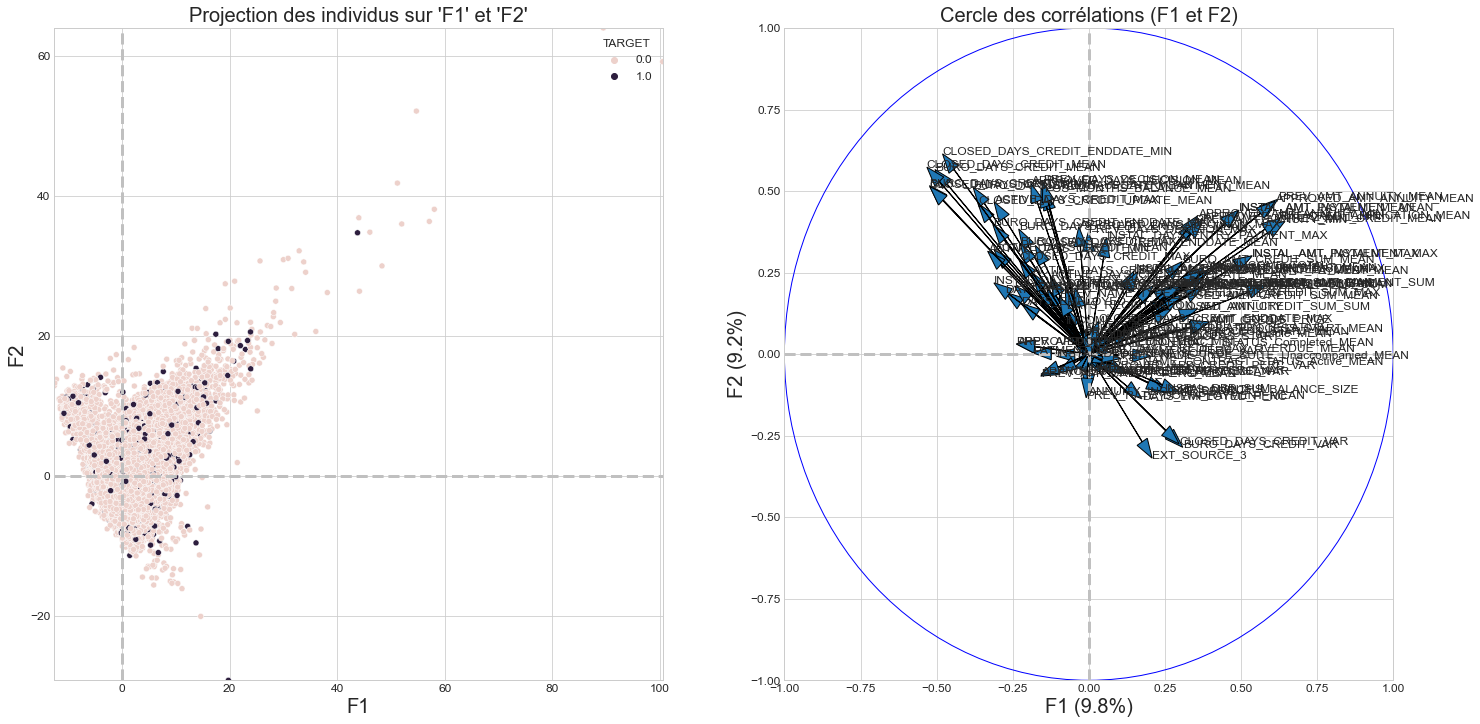

In [21]:
dth.acpAnalysis(X_train_std, y_train)

Il faudrait étudier 28 composantes principales pour avoir une représentation de 80% de l'intertie du nuage de points des individus. En se contentant d'observer les 2 premières on remarque qu'il est difficile d'en retirer de l'information pertinente. 

- Les répartitions des valeurs TARGET 0 et 1 sont confondus, il est impossible de les séparer distinctement.
- Sur le cercle des corrélations, il y'a beaucoup de features et de corrélations confondues, ce qui rend difficile d'observer une tendance ou un comportement particulier à l'oeil.

Il sera probablement difficile d'entraîner un modèle avec d'excellent résultats de prédiction sans faire de sur-apprentissage. Il y'aura beaucoup de Faux Positifs ou de Faux négatifs.

Il va donc falloir déterminer quel type de résultat on veut obtenir pour valider notre modèle.


# Modélisation et évaluation des modèles

Dans cette partie, on va entraîner différents modèles de classification binaire et les évaluer.

On va rentrer plusieurs critères d'évaluation dans un tableau, que l'on analysera à la fin pour déterminer le modèle à choisir.

Ces critères sont par exemple :

- **Le temps d'entraînement** : temps nécessaire pour l'entraînement du modèle
- **Le temps de prédiction** : temps nécessaire pour prédire une valeur
- **Certaines métriques** : f1_score, accuracy, precision, recall, AUC
- **Une métrique personnalisée** (voir plus loin)

In [162]:
results = {}

### Modèle de référence

100%|██████████| 10/10 [00:06<00:00,  1.49trial/s, best loss: 0.014489705493790778]
Meilleurs paramètres : {'strategy': 'most_frequent'}


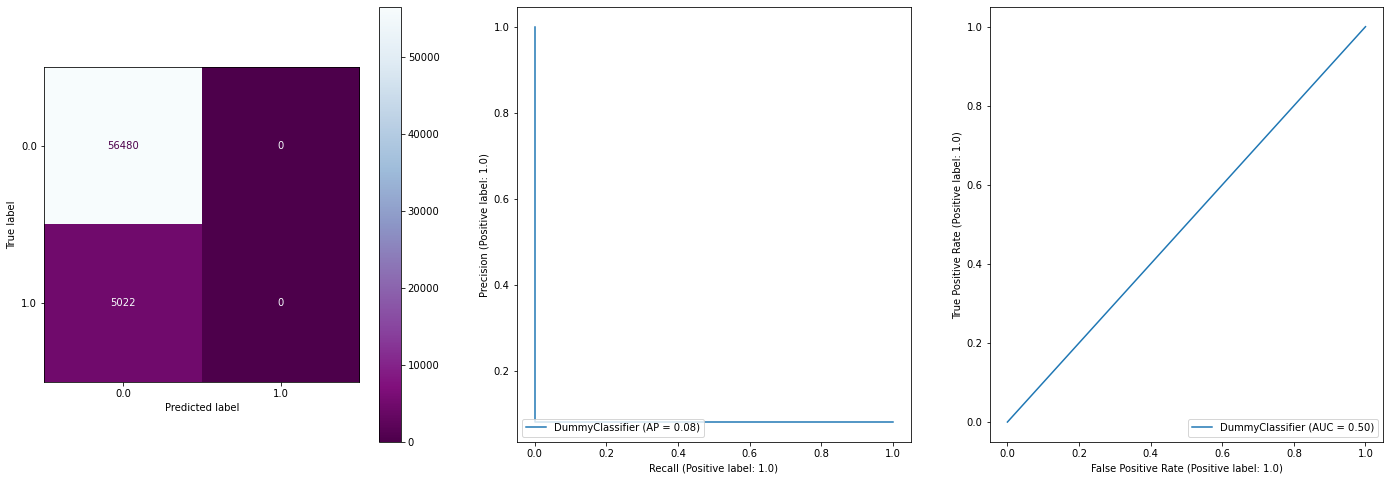

In [163]:
dummy_classifier = DummyClassifier(random_state=42)

space = {
        'strategy': hp.choice('strategy', ['stratified', 'most_frequent', 'prior', 'uniform'])
    }

dummyClassifier_results = dth.find_best_parameters(dummy_classifier, space, X_train_std, y_train, X_test_std, y_test, smote=False)

results['dummyClassifier'] = dummyClassifier_results

print(f"Meilleurs paramètres : {dummyClassifier_results['Best params']}")

dth.plot_classifier_results(dummyClassifier_results['Classifier'], X_test_std, y_test)

Ce modèle de référence prédit systématiquement la classe 0, et sert de base pour comparer nos modèles suivants.

C'est un mauvais modèle malgré une précision de 92% (du au déséquilbre des classes), car il ne prédit jamais la classe 1 pour les mauvais payeurs. On voit donc que la précision n'est pas une bonne métrique pour évaluer nos modèles.

### Métrique personnalisée

L'objectif ici sera de maximiser les True Positif tout en limitant les Faux Positif (Prédire quelqu'un comme étant dans l'impossibilité de rembourser le prêt alors que c'est faux).

Il sera impossible d'obtenir un modèle parfait qui sort la bonne prédiction à chaque fois, il faut donc trouver le juste milieu permettant de limiter les pertes pour la banque, trouver un équilivre entre False Negative et False Positive.

- **Métrique personnalisée** : on l'utilisera pour trouver nos meilleurs hyperparamètres lors de la validation de chaque modèle, puis pour choisir notre meilleur modèle.
Elle est basée sur la proportion de False Negative et False Positive, en appliquant un poids à chacun.

La banque perdra plus d'argent en se trompant sur un mauvais payeur que sur un bon payeur. On appliquera donc un poids de 0.9 aux False Negative et un poids de 0.1 aux False Positive.

Notre métrique est donc un score à minimiser : **(0.9 * FN + 0.1 * FN) / data.size**

### Oversampling avec SMOTE

Comme on l'a vu, notre jeu de données est déséquilibré, avec 92% des classes TARGET à 0, ce qui va introduire un biais lors de l'apprentissage de nos modèles. 

On va rééquilibrer ces classes en utilisant un algorithme d'oversampling, qui consiste à dupliquer une part des invididus de la classe minoritaire, afin d'obtenir un jeu de données équilibré.

![oversampling.png](data/img/oversampling.png)

Cet algorithme est le SMOTE, seulement on ne va pas l'appliquer sur notre jeu d'entraînement de départ, car il sera ensuite divisé en plusieurs folders lors des différentes validation croisées.

Et on ne veut pas qu'un jeu de test lors de la validation croisée contienne des individus dupliqués.

On va alors appliquer le SMOTE dans notre pipeline au moment de la validation croisée, et seulement sur les folders d'entraînement. Et réitérer cette opération à chaque fois.

Pour certains modèles, à la place d'utiliser le SMOTE, on utilisera le paramètre class_weight.

### Entraînement des différents modèles

On utilise un **KFold** pour séparer notre jeu d'entraînement en 5 folders qui serviront pour la validation croisée.

On utilise **hyperopt** pour trouver les meilleurs hyperparamètres, en se basant sur un score à minimiser qui est notre **métrique personnalisée** vu précedemment.

Pour chaque modèle on affichera également le top 20 du **feature_importance** : les 20 features les plus influentes sur la décision du modèle. C'est une méthode globale de mesure de l'importance des variables.

### Ridge Classifier

100%|██████████| 10/10 [07:51<00:00, 47.14s/trial, best loss: 0.013962480437389485]
Meilleurs paramètres : {'alpha': 18370.500757440783, 'fit_intercept': False, 'normalize': False, 'solver': 'sag'}


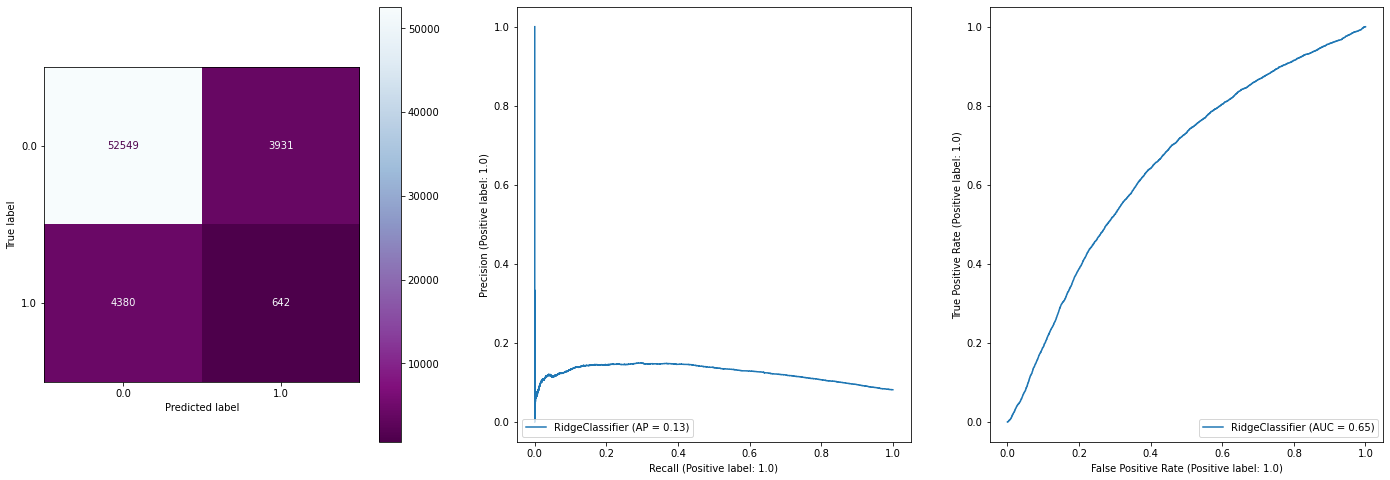

In [164]:
#SANS LE SMOTE

ridgeClassifierModel_noSmote = linear_model.RidgeClassifier(random_state=42)

space = {
        'alpha': hp.loguniform('alpha', -10, 10),
        'fit_intercept': hp.choice('fit_intercept', [True, False]),
        'normalize': hp.choice('normalize', [True, False]),
        'solver': hp.choice('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
    }

ridgeClassifier_noSmote_results = dth.find_best_parameters(ridgeClassifierModel_noSmote, space, X_train_std, y_train, X_test_std, y_test, smote=False)

results['ridgeClassifier_noSmote'] = ridgeClassifier_noSmote_results

print(f"Meilleurs paramètres : {ridgeClassifier_noSmote_results['Best params']}")

dth.plot_classifier_results(ridgeClassifier_noSmote_results['Classifier'], X_test_std, y_test)

Cet exemple sans le SMOTE permet de prouver que le SMOTE est important pour ne pas biaiser notre apprentissage.

Ici le taux de True Positive n'est pas assez important

100%|██████████| 10/10 [32:37<00:00, 195.76s/trial, best loss: 0.010367594154590355]
Meilleurs paramètres : {'alpha': 0.7505689576188825, 'fit_intercept': True, 'normalize': False, 'solver': 'sag'}


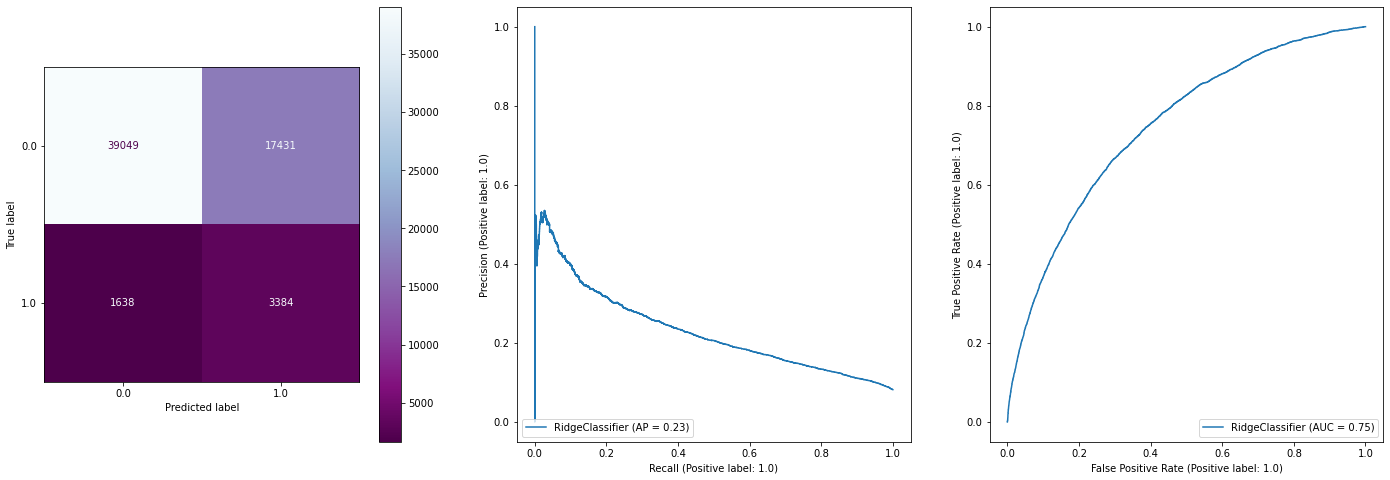

In [165]:
#AVEC LE SMOTE

ridgeClassifierModel = linear_model.RidgeClassifier(random_state=42)

space = {
        'alpha': hp.loguniform('alpha', -10, 10),
        'fit_intercept': hp.choice('fit_intercept', [True, False]),
        'normalize': hp.choice('normalize', [True, False]),
        'solver': hp.choice('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
    }

ridgeClassifier_results = dth.find_best_parameters(ridgeClassifierModel, space, X_train_std, y_train, X_test_std, y_test, smote=True)

results['ridgeClassifier'] = ridgeClassifier_results

print(f"Meilleurs paramètres : {ridgeClassifier_results['Best params']}")

dth.plot_classifier_results(ridgeClassifier_results['Classifier'], X_test_std, y_test)

Avec le SMOTE appliqué pour le même modèle, nos résultats sont beaucoup plus précis

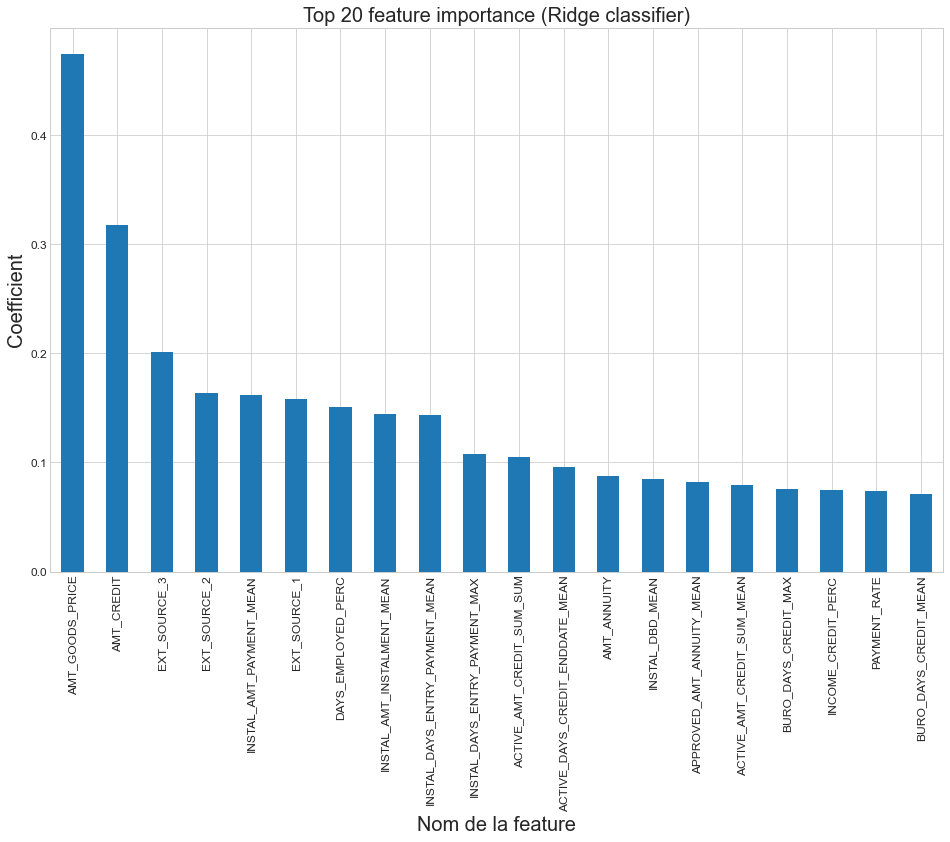

In [524]:
top_coefficients = pd.Series(
            ridgeClassifier_results['Classifier'].coef_[0],
            X_test_std.columns,
        ).map(abs).sort_values(ascending=False).head(20)
        
plt.figure(figsize=(16, 10))
top_coefficients.plot.bar()
plt.title('Top 20 feature importance (Ridge classifier)')
plt.xlabel('Nom de la feature')
plt.ylabel('Coefficient')
plt.show()

### RandomForest, avec SMOTE et avec class_weight

100%|██████████| 10/10 [1:21:37<00:00, 489.72s/trial, best loss: 0.011396435031808299]
Meilleurs paramètres : {'max_depth': 11, 'max_features': 'sqrt'}


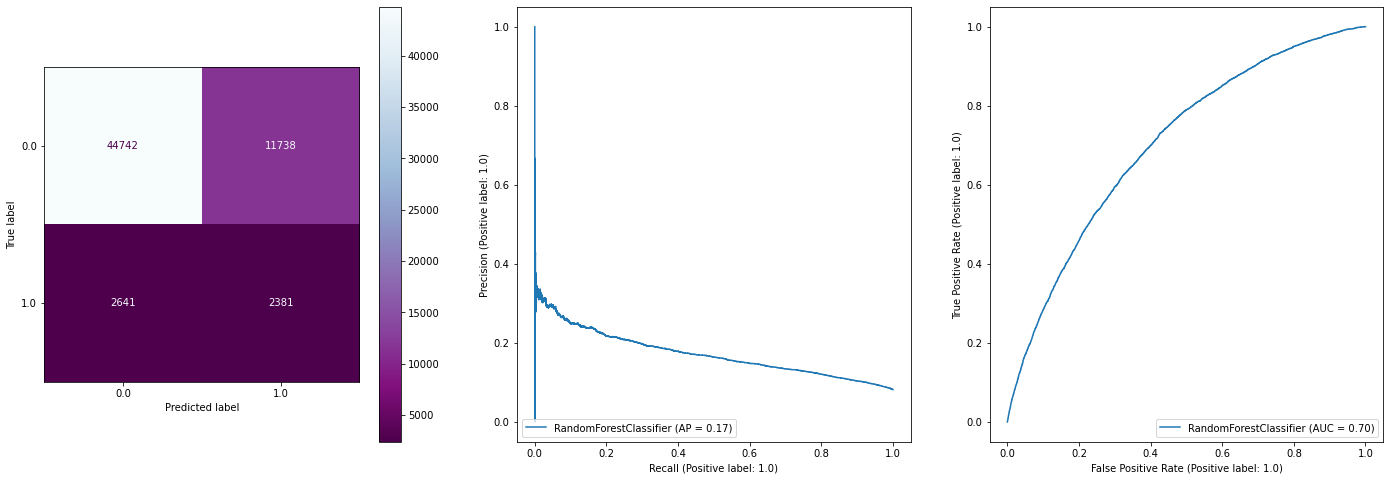

In [167]:
randomForestModel = ensemble.RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

space = {
        'max_depth': hp.choice('max_depth', [None] + list(range(2, 20, 3))),
        'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2'])
        }

randomForest_results = dth.find_best_parameters(randomForestModel, space, X_train_std, y_train, X_test_std, y_test, smote=True)

results['randomForestClassifier'] = randomForest_results

print(f"Meilleurs paramètres : {randomForest_results['Best params']}")

dth.plot_classifier_results(randomForest_results['Classifier'], X_test_std, y_test)

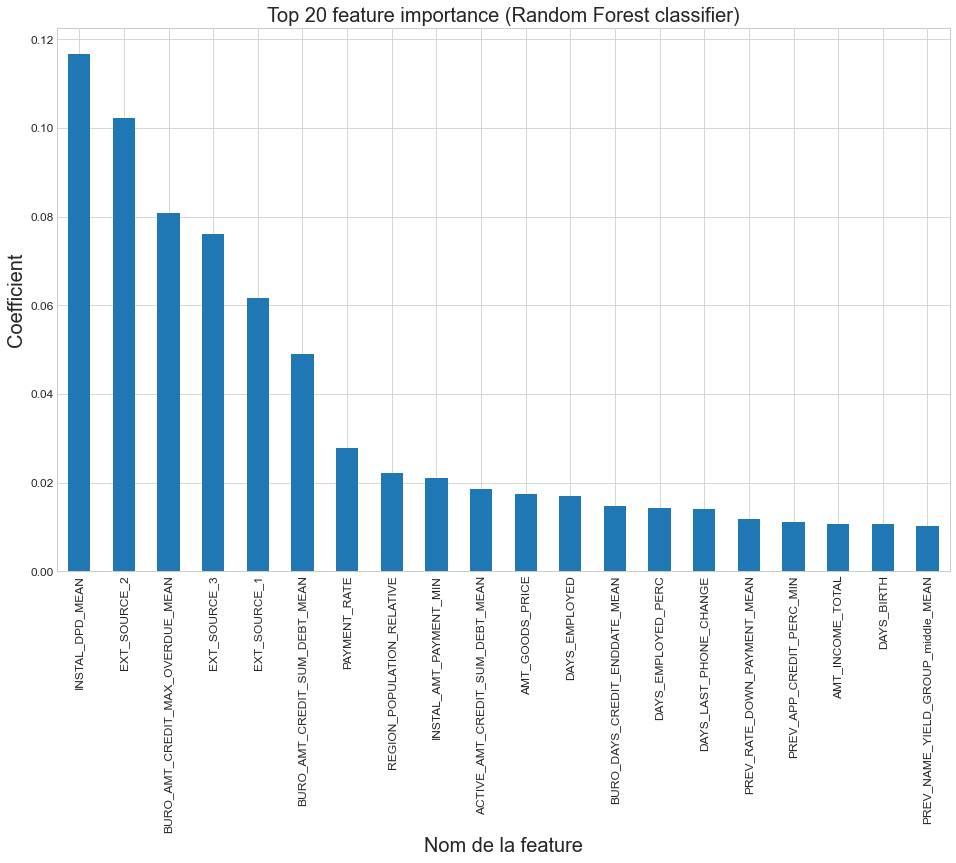

In [525]:
top_coefficients = pd.Series(
            randomForest_results['Classifier'].feature_importances_,
            X_test_std.columns,
        ).map(abs).sort_values(ascending=False).head(20)

plt.figure(figsize=(16, 10))
top_coefficients.plot.bar()
plt.title('Top 20 feature importance (Random Forest classifier)')
plt.xlabel('Nom de la feature')
plt.ylabel('Coefficient')
plt.show()

100%|██████████| 10/10 [44:02<00:00, 264.25s/trial, best loss: 0.010393853783459688]
Meilleurs paramètres : {'max_depth': 8, 'max_features': 'auto'}


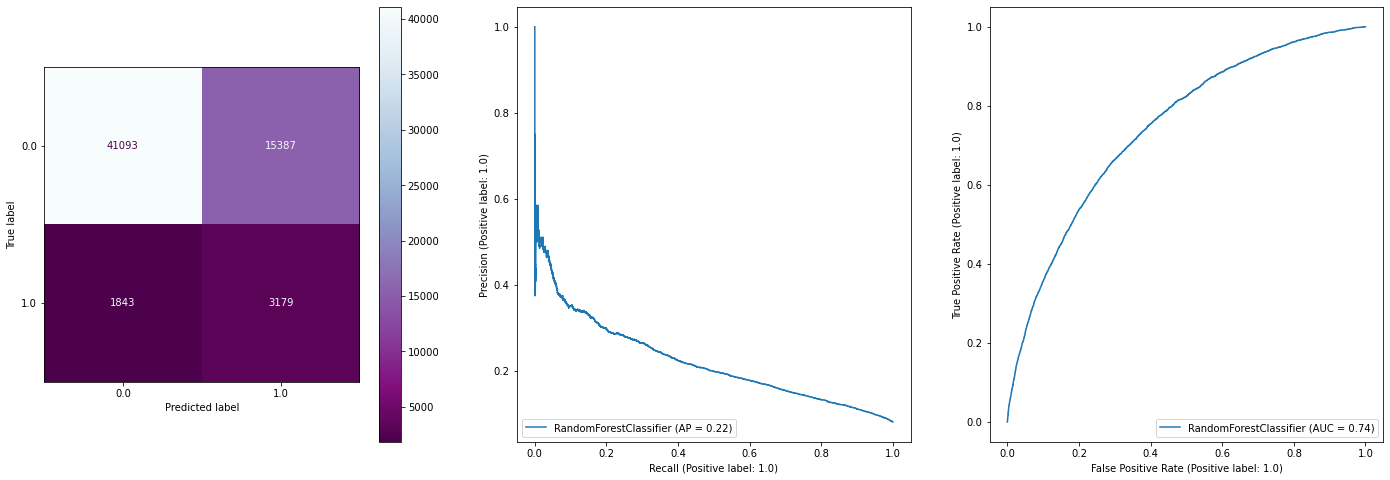

In [357]:
randomForestModel_classWeight = ensemble.RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, class_weight='balanced')

space = {
        'max_depth': hp.choice('max_depth', [None] + list(range(2, 20, 3))),
        'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2'])
        }

randomForest_classWeight_results = dth.find_best_parameters(randomForestModel_classWeight, space, X_train_std, y_train, X_test_std, y_test, smote=False)

results['randomForestClassifier_classWeight'] = randomForest_classWeight_results

print(f"Meilleurs paramètres : {randomForest_classWeight_results['Best params']}")

dth.plot_classifier_results(randomForest_classWeight_results['Classifier'], X_test_std, y_test)

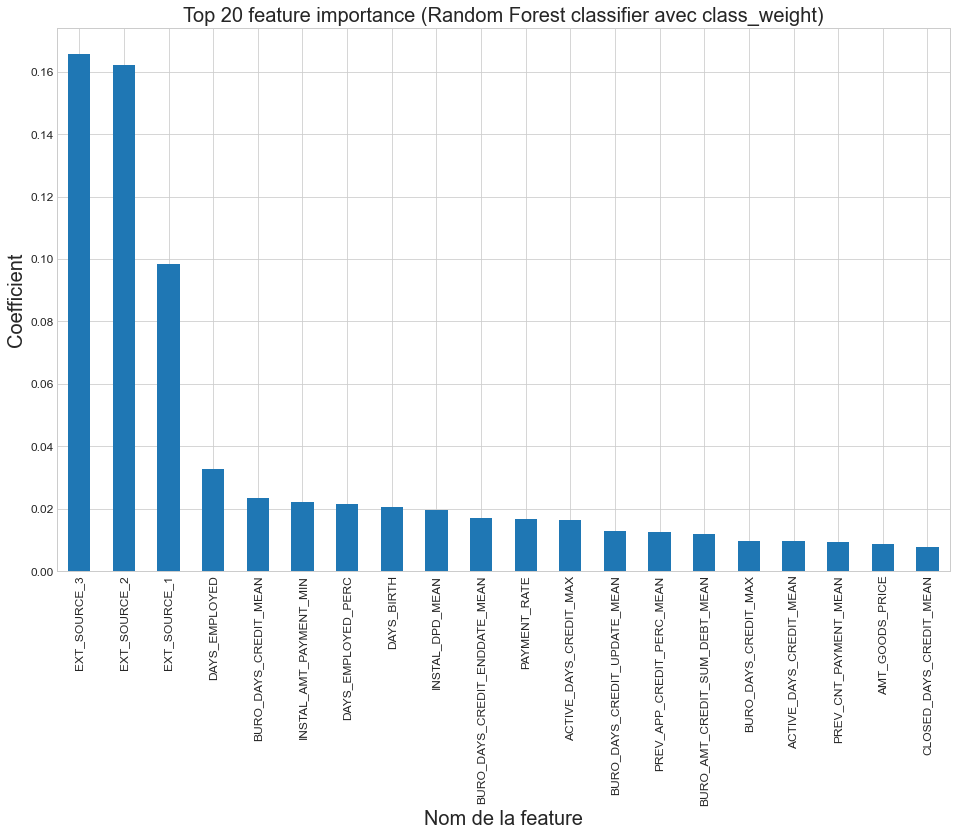

In [526]:
top_coefficients = pd.Series(
            randomForest_classWeight_results['Classifier'].feature_importances_,
            X_test_std.columns,
        ).map(abs).sort_values(ascending=False).head(20)

plt.figure(figsize=(16, 10))
top_coefficients.plot.bar()
plt.title('Top 20 feature importance (Random Forest classifier avec class_weight)')
plt.xlabel('Nom de la feature')
plt.ylabel('Coefficient')
plt.show()

### LGBM Classifier, avec SMOTE et avec class_weight

100%|██████████| 10/10 [11:25<00:00, 68.52s/trial, best loss: 0.012340968679498384]
Best parameters : {'max_depth': 3}


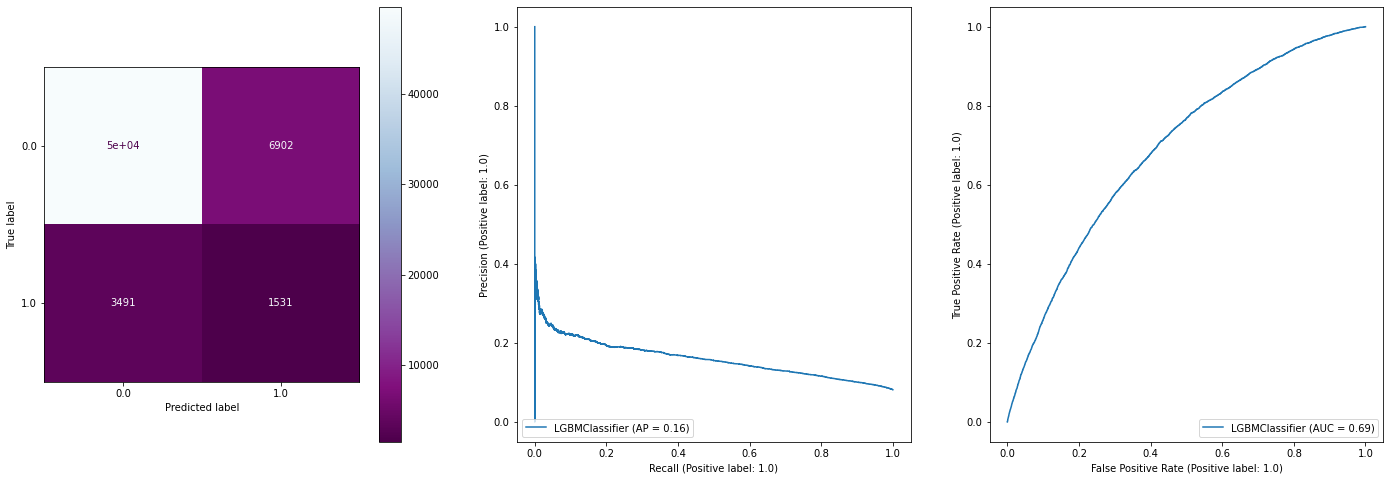

In [346]:
lgbmModel = LGBMClassifier(n_jobs=-1, random_state=42, objective='binary')

space = {
        'max_depth': hp.choice('max_depth', [None] + list(range(0, 22, 3)))
        }

lgbmClassifier_results = dth.find_best_parameters(lgbmModel, space, X_train_std, y_train, X_test_std, y_test, smote=True)

results['lgbmClassifier'] = lgbmClassifier_results

print(f"Best parameters : {lgbmClassifier_results['Best params']}")

dth.plot_classifier_results(lgbmClassifier_results['Classifier'], X_test_std, y_test)

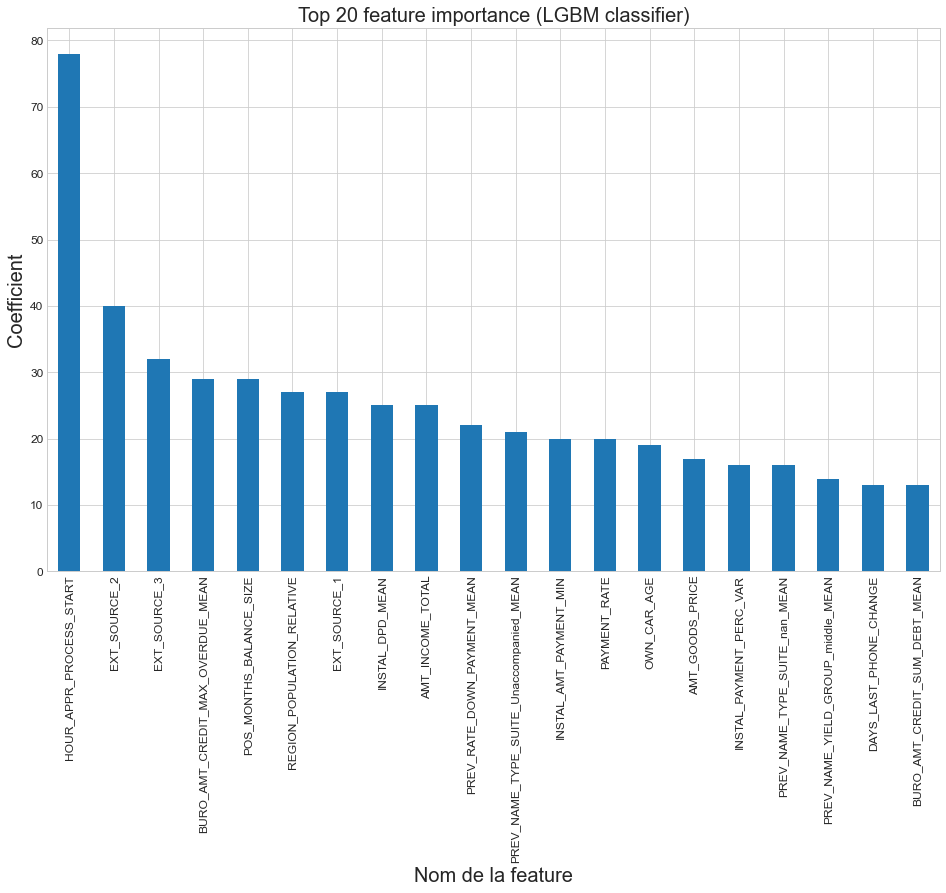

In [527]:
top_coefficients = pd.Series(
            lgbmClassifier_results['Classifier'].feature_importances_,
            X_test_std.columns,
        ).map(abs).sort_values(ascending=False).head(20)

plt.figure(figsize=(16, 10))
top_coefficients.plot.bar()
plt.title('Top 20 feature importance (LGBM classifier)')
plt.xlabel('Nom de la feature')
plt.ylabel('Coefficient')
plt.show()

100%|██████████| 10/10 [05:31<00:00, 33.12s/trial, best loss: 0.00968451860734538]
Best parameters : {'max_depth': None}


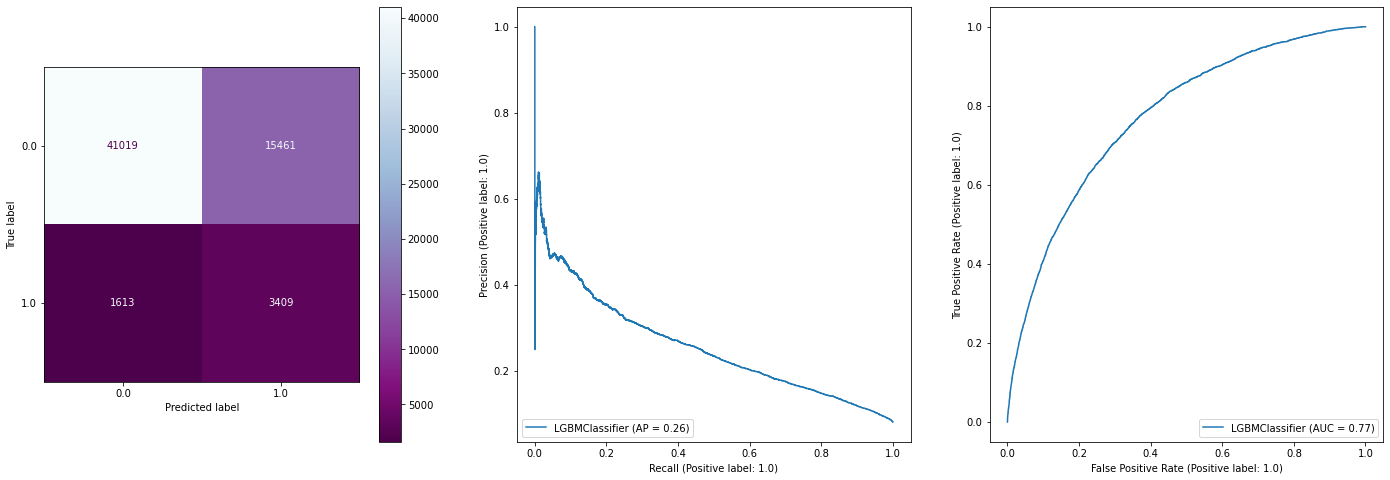

In [354]:
lgbmModel_classWeight = LGBMClassifier(n_jobs=-1, random_state=42, objective='binary', class_weight='balanced')

space = {
        'max_depth': hp.choice('max_depth', [None] + list(range(0, 22, 3)))
        }

lgbmClassifier_classWeight_results = dth.find_best_parameters(lgbmModel_classWeight, space, X_train_std, y_train, X_test_std, y_test, smote=False)

results['lgbmClassifier_classWeight'] = lgbmClassifier_classWeight_results

print(f"Best parameters : {lgbmClassifier_classWeight_results['Best params']}")

dth.plot_classifier_results(lgbmClassifier_classWeight_results['Classifier'], X_test_std, y_test)

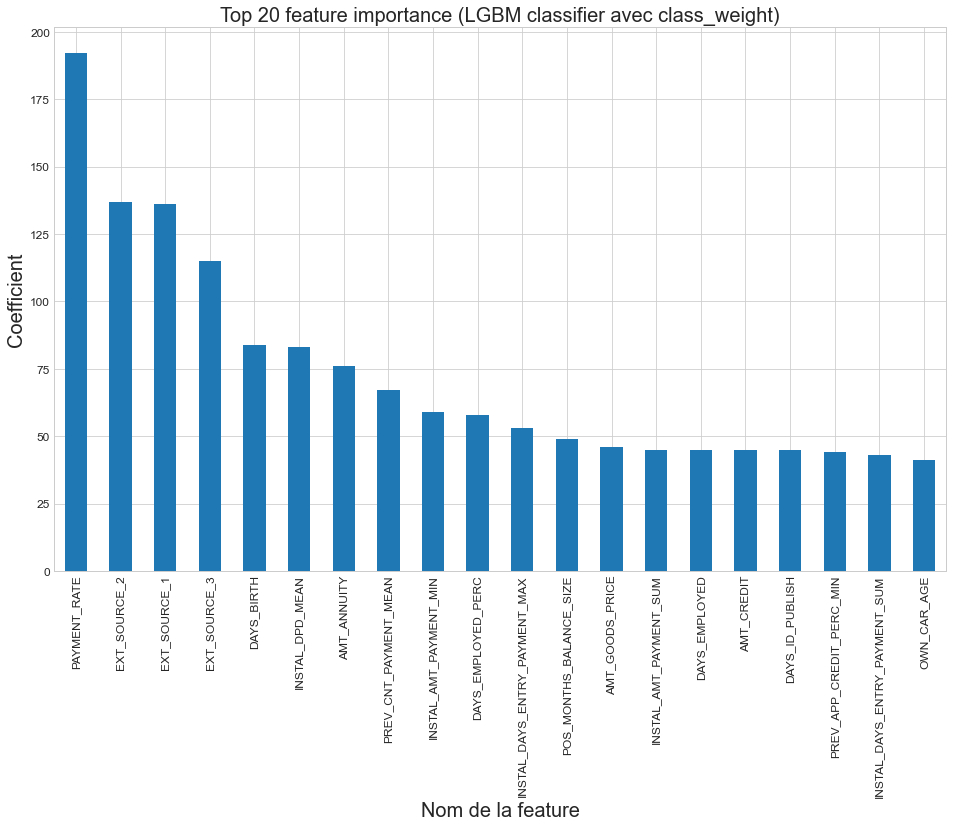

In [528]:
top_coefficients = pd.Series(
            lgbmClassifier_classWeight_results['Classifier'].feature_importances_,
            X_test_std.columns,
        ).map(abs).sort_values(ascending=False).head(20)

plt.figure(figsize=(16, 10))
top_coefficients.plot.bar()
plt.title('Top 20 feature importance (LGBM classifier avec class_weight)')
plt.xlabel('Nom de la feature')
plt.ylabel('Coefficient')
plt.show()

### Linear SVC

100%|██████████| 10/10 [26:11<00:00, 157.19s/trial, best loss: 0.010325237291924963]
Meilleurs paramètres : {'C': 3.1306372213876936}


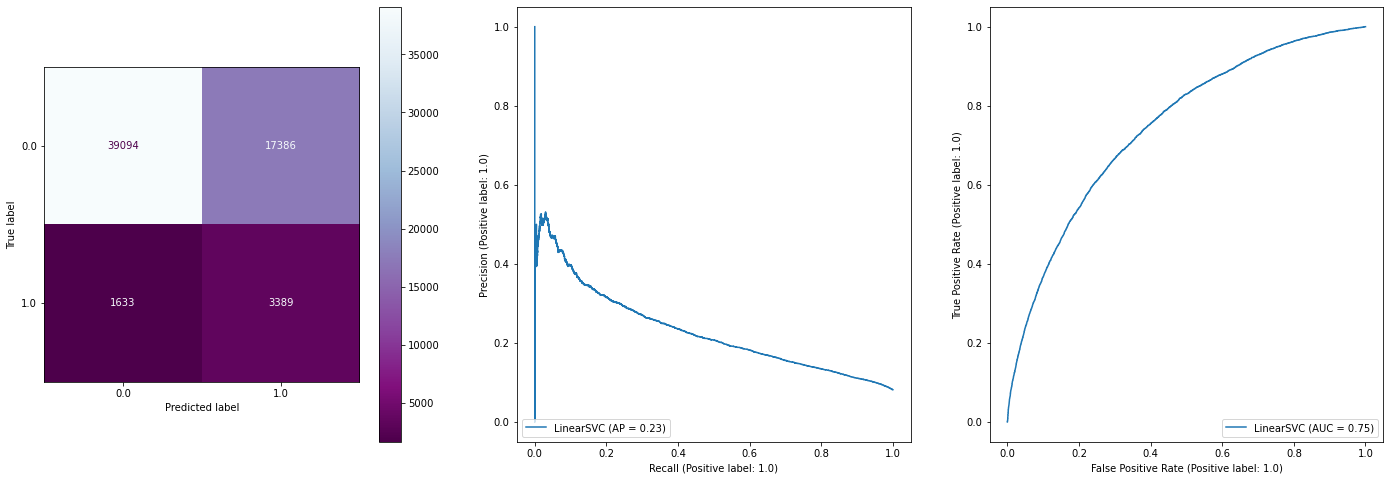

In [171]:
svcModel = LinearSVC(random_state=42, tol=1e-5, dual=False)

space = {
        'C': hp.loguniform('C', 1, 10),
        }

svc_results = dth.find_best_parameters(svcModel, space, X_train_std, y_train, X_test_std, y_test, smote=True)

results['svcClassifier'] = svc_results

print(f"Meilleurs paramètres : {svc_results['Best params']}")

dth.plot_classifier_results(svc_results['Classifier'], X_test_std, y_test)

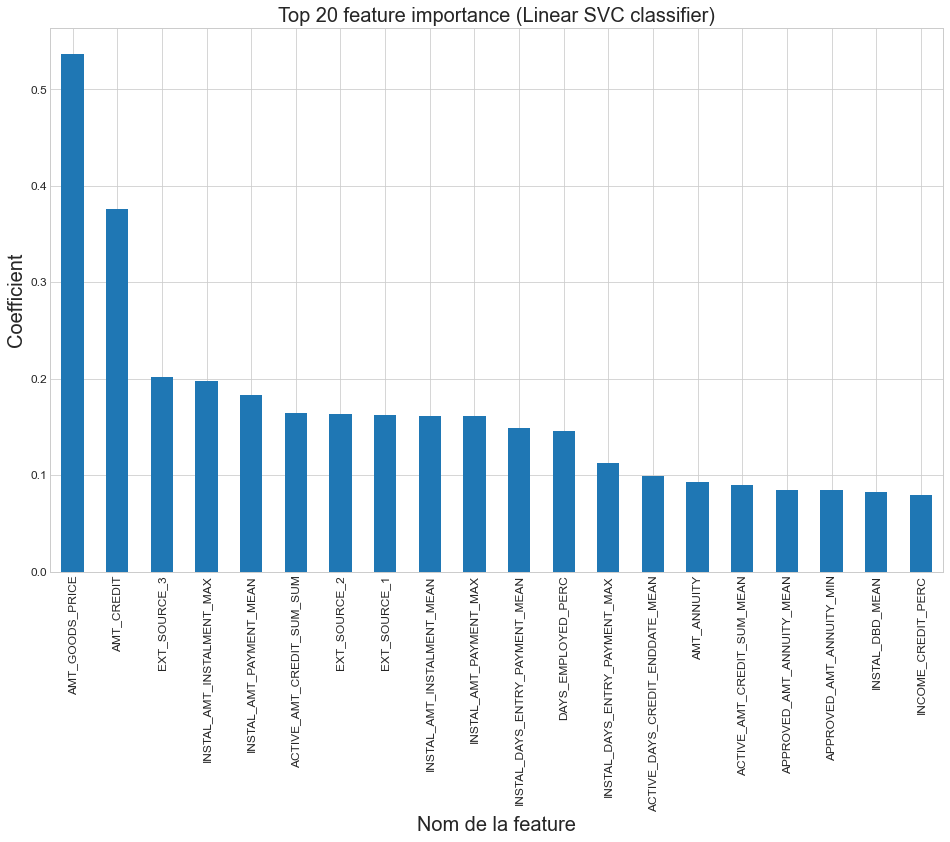

In [529]:
top_coefficients = pd.Series(
            svc_results['Classifier'].coef_[0],
            X_test_std.columns,
        ).map(abs).sort_values(ascending=False).head(20)

plt.figure(figsize=(16, 10))
top_coefficients.plot.bar()
plt.title('Top 20 feature importance (Linear SVC classifier)')
plt.xlabel('Nom de la feature')
plt.ylabel('Coefficient')
plt.show()

## Tableau récapitulatif

In [365]:
pd.DataFrame.from_dict(results, orient='index')

Classifier  \
dummyClassifier                     DummyClassifier(random_state=42, strategy='mos...   
ridgeClassifier_noSmote             RidgeClassifier(alpha=18370.500757440783, fit_...   
ridgeClassifier                     RidgeClassifier(alpha=0.7505689576188825, norm...   
randomForestClassifier              (DecisionTreeClassifier(max_depth=11, max_feat...   
lgbmClassifier                      LGBMClassifier(max_depth=3, objective='binary'...   
svcClassifier                       LinearSVC(C=3.1306372213876936, dual=False, ra...   
lgbmClassifier_classWeight          LGBMClassifier(class_weight='balanced', max_de...   
randomForestClassifier_classWeight  (DecisionTreeClassifier(max_depth=8, max_featu...   

                                                                          Best params  \
dummyClassifier                                         {'strategy': 'most_frequent'}   
ridgeClassifier_noSmote             {'alpha': 18370.500757440783, 'fit_intercept':...   
ridgeClassifier                     {'alpha': 0.7505689576188825, 'fit_intercept':...   
randomForestClassifier                      {'max_depth': 11, 'max_features': 'sqrt'}   
lgbmClassifier                                                       {'max_depth': 3}   
svcClassifier                                               {'C': 3.1306372213876936}   
lgbmClassifier_classWeight                                        {'max_depth': None}   
randomForestClassifier_classWeight           {'max_depth': 8, 'max_features': 'auto'}   

                                    Predict time  Training time  \
dummyClassifier                         0.000966       6.734963   
ridgeClassifier_noSmote                 0.011969     471.403331   
ridgeClassifier                         0.026902    1957.636500   
randomForestClassifier                  0.436888    4897.157357   
lgbmClassifier                          0.185503     685.200938   
svcClassifier                           0.019947    1571.873887   
lgbmClassifier_classWeight              0.191488     331.184315   
randomForestClassifier_classWeight      0.533574    2642.465243   

                                    Personnalised metric  \
dummyClassifier                                 0.018373   
ridgeClassifier_noSmote                         0.017622   
ridgeClassifier                                 0.013078   
randomForestClassifier                          0.014433   
lgbmClassifier                                  0.015577   
svcClassifier                                   0.013042   
lgbmClassifier_classWeight                      0.012186   
randomForestClassifier_classWeight              0.012997   

                                                  Confusion matrix  f1 score  \
dummyClassifier                            [[56480, 0], [5022, 0]]  0.000000   
ridgeClassifier_noSmote               [[52549, 3931], [4380, 642]]  0.133820   
ridgeClassifier                     [[39049, 17431], [1638, 3384]]  0.261950   
randomForestClassifier              [[44742, 11738], [2641, 2381]]  0.248785   
lgbmClassifier                       [[49578, 6902], [3491, 1531]]  0.227573   
svcClassifier                       [[39094, 17386], [1633, 3389]]  0.262744   
lgbmClassifier_classWeight          [[41019, 15461], [1613, 3409]]  0.285367   
randomForestClassifier_classWeight  [[41093, 15387], [1843, 3179]]  0.269544   

                                    accuracy  precision    recall       AUC  \
dummyClassifier                     0.918344   0.000000  0.000000  0.500000   
ridgeClassifier_noSmote             0.864866   0.140389  0.127838  0.652428   
ridgeClassifier                     0.689945   0.162575  0.673835  0.747171   
randomForestClassifier              0.766203   0.168638  0.474114  0.704938   
lgbmClassifier                      0.831014   0.181549  0.304859  0.690178   
svcClassifier                       0.690758   0.163129  0.674831  0.747505   
lgbmClassifier_classWeight          0.722383   0.180

Certains modèles sont beaucoup plus rapides que d'autres à entraîner.

Concernant les différentes métriques, les écarts sont moins importants mais on peut quand même distinguer le meilleur modèle.

Il s'agit ici du **LGBM Classifier avec le class_weight**, de plus son temps d'entraînement et de prédiction n'est pas trop long.

Pour ce modèle :
- La métrique personnalisée que l'on a défini précedemment a le score le plus faible, ce que l'on cherchait à obtenir. 
- L'aire sous la courve ROC est la plus élevée. 
- La précision moyenne et le recall sont également les élevés.

En observant la matrice de confusion, on voit que c'est ce modèle qui arrive à prédire le plus de True Positive tout en minimisant les False Positive. C'est à dire prédire le plus de mauvais payeurs tout en se trompant moins sur les bons payeurs.

En ce qui concerne son feature_importance, voici les 5 features qui impactent le plus le choix du modèle :

- PAYMENT_RATE
- EXT_SOURCE_2
- EXT_SOURCE_1
- EXT_SOURCE_3
- DAYS_BIRTH

Les clients ont le moins de risque d'avoir un problème à rembourser un prêt quand ils ont un EXT_SOURCE élevé ou un PAYMENT_RATE élevé.

Cela correspond aux features que l'on avait trouvé corrélées avec la colonne TARGET dans la partie analyse.

Dans les features suivantes, on retrouve des features que l'on avait crée dans la partie analyse et manipulation des données

## LIME and SHAP

On va utiliser les algorithmes LIME et SHAP afin d'interpréter un peu mieux notre modèle. Ce sont des méthodes locale de mesure de l'importance des variables.

- LIME : c'est un modèle local qui cherche à expliquer la prédiction d’un individu par analyse de son voisinage. Il indique les variables favorables ou dévorables à cet individu.
- SHAP : c'est un algorithme qui moyenne l’impact qu’une variable a pour toutes les combinaisons de variables possibles.

In [488]:
y_pred = lgbmClassifier_classWeight_results['Classifier'].predict(X_test_std)

frame = {'true_value': y_test, 'predicted': y_pred}
data_target = pd.DataFrame(frame)
data_target.reset_index(inplace=True)

tp_list = data_target[(data_target['true_value'] == 1) & (data_target['predicted'] == 1)].index.tolist()
tn_list = data_target[(data_target['true_value'] == 0) & (data_target['predicted'] == 0)].index.tolist()
fp_list = data_target[(data_target['true_value'] == 0) & (data_target['predicted'] == 1)].index.tolist()
fn_list = data_target[(data_target['true_value'] == 1) & (data_target['predicted'] == 0)].index.tolist()

On va utiliser le LIME et SHAP sur des individus tirés au hasard parmis les 4 catégories de prédiction de la matrice de confusion :
True Positive, True Negative, False Positive, False Negative

Cela permet de comprendre un peu mieux comment est price la décision de notre modèle.

#### True Positive

In [490]:
tp_index = random.choice(tp_list)
dth.lime(lgbmClassifier_classWeight_results['Classifier'], tp_index, X_train_std, X_test_std, y_test)

Vraie valeur : 1.0


In [491]:
explainer = shap.Explainer(lgbmClassifier_classWeight_results['Classifier'])
shap_values = explainer.shap_values(X_test_std)

print(f"Vraie valeur : {y_test.iloc[tp_index]}")
shap.force_plot(explainer.expected_value[1], shap_values[1][tp_index,:], X_test_std.iloc[tp_index,:])

Vraie valeur : 1.0


#### True Negative

In [492]:
tn_index = random.choice(tn_list)
dth.lime(lgbmClassifier_classWeight_results['Classifier'], tn_index, X_train_std, X_test_std, y_test)

Vraie valeur : 0.0


In [493]:
explainer = shap.Explainer(lgbmClassifier_classWeight_results['Classifier'])
shap_values = explainer.shap_values(X_test_std)

print(f"Vraie valeur : {y_test.iloc[tn_index]}")
shap.force_plot(explainer.expected_value[1], shap_values[1][tn_index,:], X_test_std.iloc[tn_index,:])

Vraie valeur : 0.0


#### False Positive

In [496]:
fp_index = random.choice(fp_list)
dth.lime(lgbmClassifier_classWeight_results['Classifier'], fp_index, X_train_std, X_test_std, y_test)

Vraie valeur : 0.0


In [497]:
explainer = shap.Explainer(lgbmClassifier_classWeight_results['Classifier'])
shap_values = explainer.shap_values(X_test_std)

print(f"Vraie valeur : {y_test.iloc[fp_index]}")
shap.force_plot(explainer.expected_value[1], shap_values[1][fp_index,:], X_test_std.iloc[fp_index,:])

Vraie valeur : 0.0


#### False Negative

In [498]:
fn_index = random.choice(fn_list)
dth.lime(lgbmClassifier_classWeight_results['Classifier'], fn_index, X_train_std, X_test_std, y_test)

Vraie valeur : 1.0


In [499]:
explainer = shap.Explainer(lgbmClassifier_classWeight_results['Classifier'])
shap_values = explainer.shap_values(X_test_std)

print(f"Vraie valeur : {y_test.iloc[fn_index]}")
shap.force_plot(explainer.expected_value[1], shap_values[1][fn_index,:], X_test_std.iloc[fn_index,:])

Vraie valeur : 1.0


## Conclusion

Le modèle est loin d'être parfait, mais avec les données en notre possession il est difficile de mieux faire.

Il classe déjà plutôt bien la plupart des clients, mais il reste encore environ 1/3 des mauvais payeurs qu'il n'arrive pas à prédire correctement.
Il fait également quelques erreurs sur les clients bons payeurs.

Pour améliorer la précision de notre modèle, il faudrait de nouvelles features permettant une démarcation plus net entre les clients qui remboursent et ceux qui ne remboursent pas.

On peut déjà comprendre comment notre modèle classe les clients, et l'impact qu'ont certaines features sur la décision de notre modèle. Ce qui permet si besoin de comprendre localement comment une décision a été prise pour un client en particulier.